In [1]:
# import modules
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from IPython.display import display
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import scipy

In [2]:
train = pd.read_csv("../input/tabular-playground-series-apr-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-apr-2022/test.csv")
submission = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")
labels = pd.read_csv("../input/tabular-playground-series-apr-2022/train_labels.csv")

In [3]:
train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


In [4]:
test.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.0,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.0,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.0,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.0,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.0,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483


In [5]:
labels.head()

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


In [6]:
def engineering(df):
    for sensor in sensors:
        # add lag feature and difference
        df[sensor + '_lag'] = df.groupby('sequence')[sensor].shift(1)
        df.fillna(0, inplace=True)
        # df[sensor + '_diff'] = df[sensor] - df[sensor + '_lag']    
    return df

In [7]:
sensors = [col for col in train.columns if 'sensor_' in col]
train = engineering(train)
test = engineering(test)

In [8]:
groups = train['sequence']
train = train.drop(['sequence', 'subject', 'step'], inplace=False, axis=1).values
test = test.drop(['sequence', 'subject', 'step'], inplace=False, axis=1).values
labels = labels['state']

In [9]:
scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [10]:
print(train.shape)
print(test.shape)

# reshape dataset as an input of LSTM model
train = train.reshape(int(len(train)/60), 60, train.shape[-1])
test = test.reshape(int(len(test)/60), 60, test.shape[-1])

print(f'train reshape: {train.shape}')
print(f'test reshape: {test.shape}')

(1558080, 26)
(733080, 26)
train reshape: (25968, 60, 26)
test reshape: (12218, 60, 26)


In [11]:
def BuildNN():
    # with tpu_strategy.scope():
    model = keras.models.Sequential([
        keras.layers.Input(shape=(60, 26)),
        keras.layers.LSTM(1024, return_sequences=True, name='LSTM_0'),
        keras.layers.LSTM(512, return_sequences=True, name='LSTM_1'),
        keras.layers.LSTM(256, return_sequences=True, name='LSTM_2'),
        keras.layers.LSTM(128, return_sequences=True, name='LSTM_3'),
        
        keras.layers.Conv1D(32, 7),
        keras.layers.MaxPooling1D(),
        keras.layers.Conv1D(64, 3),
        keras.layers.MaxPooling1D(),
        keras.layers.Conv1D(128, 3),
        keras.layers.GlobalMaxPooling1D(),
        
        keras.layers.Dense(150, activation="swish"),
        keras.layers.Dense(50, activation="swish"),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[keras.metrics.AUC()])
    return model

In [12]:
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [13]:
cv_score = 0
test_preds = []
kf = GroupKFold(n_splits=5)

for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(train, labels, groups.unique())):
    # split train and label into X, y train and valid set.
    X_train, X_valid = train[train_idx], train[valid_idx]
    y_train, y_valid = labels.iloc[train_idx].values, labels.iloc[valid_idx].values
    
    # Run the model
    model = BuildNN()
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=256, 
              callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
    
    # add roc_auc_score of each fold
    score = roc_auc_score(y_valid, model.predict(X_valid).squeeze())
    print(score)
    cv_score += score
    
    # append predictions
    test_preds.append(model.predict(test).squeeze())
    
print(cv_score/5)

2022-04-19 00:49:41.188694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 00:49:41.286366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 00:49:41.287087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 00:49:41.288228: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/100


2022-04-19 00:49:51.234659: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


82/82 [==============================] - 25s 176ms/step - loss: 0.6308 - auc: 0.6983 - val_loss: 0.5967 - val_auc: 0.7618
Epoch 2/100
82/82 [==============================] - 13s 159ms/step - loss: 0.5255 - auc: 0.8133 - val_loss: 0.5265 - val_auc: 0.8511
Epoch 3/100
82/82 [==============================] - 13s 159ms/step - loss: 0.4421 - auc: 0.8746 - val_loss: 0.4423 - val_auc: 0.8859
Epoch 4/100
82/82 [==============================] - 13s 160ms/step - loss: 0.3792 - auc: 0.9097 - val_loss: 0.3764 - val_auc: 0.9110
Epoch 5/100
82/82 [==============================] - 13s 159ms/step - loss: 0.3495 - auc: 0.9240 - val_loss: 0.3674 - val_auc: 0.9190
Epoch 6/100
82/82 [==============================] - 13s 159ms/step - loss: 0.3258 - auc: 0.9346 - val_loss: 0.3610 - val_auc: 0.9350
Epoch 7/100
82/82 [==============================] - 13s 159ms/step - loss: 0.2953 - auc: 0.9465 - val_loss: 0.3283 - val_auc: 0.9360
Epoch 8/100
82/82 [==============================] - 13s 159ms/step - loss

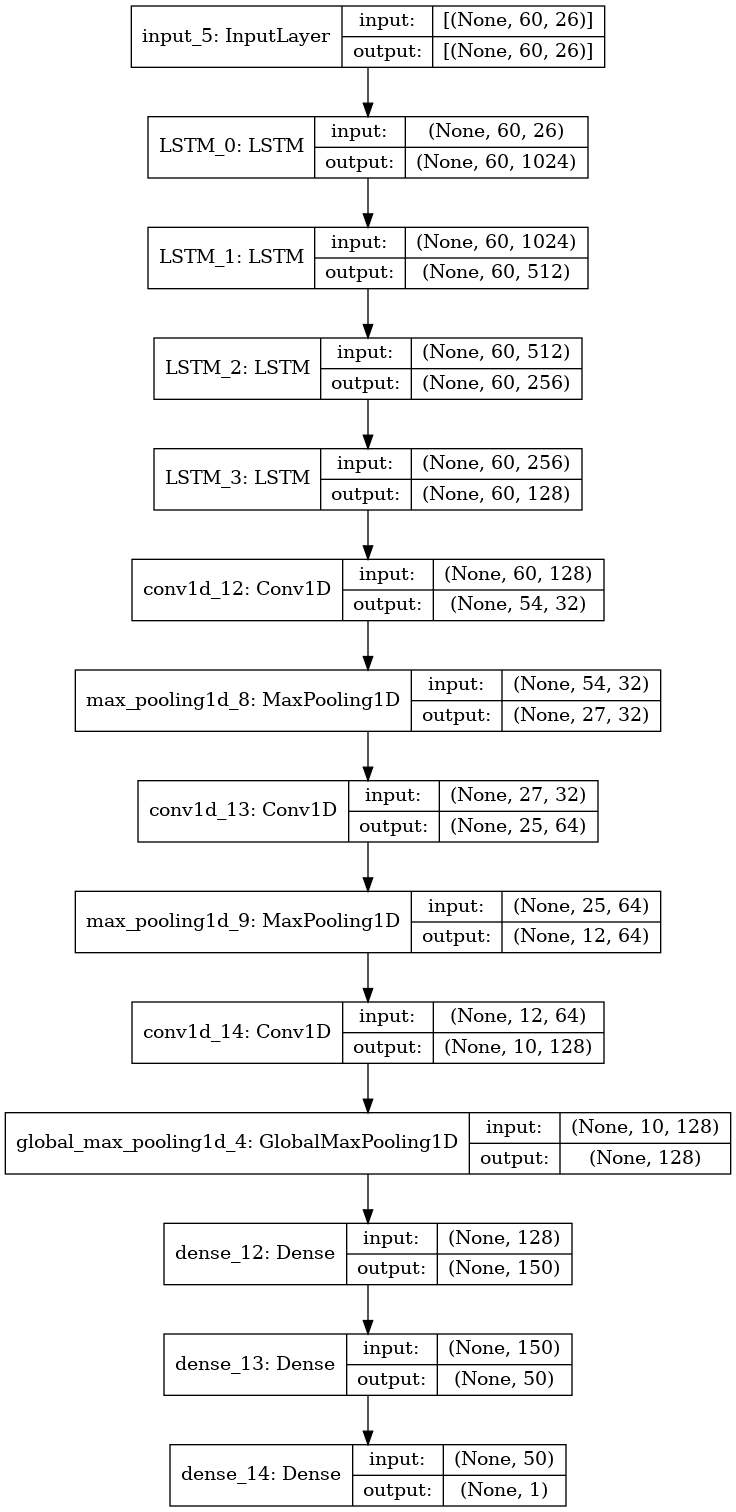

In [14]:
keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
submission["state"] = sum(test_preds)/5
submission.to_csv("submission.csv", index=False)
submission.head()

,sequence,state
0,25968,0.975699
1,25969,0.996339
2,25970,0.013857
3,25971,0.645039
4,25972,0.669625
